In [14]:
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
import plotly.express as px
import plotly.io as pio
import seaborn as sns

from pathlib import Path
import pandas as pd
import numpy as np
import itertools
import glob

import statsmodels.api as sm
import scipy.stats as stats

import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.model_selection import train_test_split
from sklearn.metrics import *

import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go

pio.renderers.default = "iframe"

In [15]:
def fix_up_df(df: pd.DataFrame):
    df["z"] = df.z.fillna(0)
    df["za"] = df.za.fillna(0)
    df["information_remaining"] = df.n_craters_in_study_region / df.n_craters_added_in_study_region
    df["removals"] = df.n_craters_added_in_study_region - df.n_craters_in_study_region
    return df

In [16]:
def plot_n_ad_and_ir_for_simulation(simulation_id: int, stats_df: pd.DataFrame):
    df = stats_df[stats_df.simulation_id == simulation_id]
    df.head()
    
    print(df[["slope", "effective_radius_multiplier", "r_stat_multiplier", "min_rim_percentage"]].iloc[0])
    
    fig = plt.figure(figsize=(18, 4))
    ax1 = fig.add_subplot(121)
    
    plt1 = ax1.plot(df.n_craters_added_in_study_region, df.information_remaining, color='red', label="Information Remaining")
    ax1.set_ylabel("Information Remaining")
    ax1.set_xlabel("N Craters Added")
    
    ax2 = ax1.twinx()
    plt2 = ax2.plot(df.n_craters_added_in_study_region, df.areal_density, color="blue", label="Areal Density")
    ax2.set_ylabel("Areal Density")
    
    lns = plt1 + plt2
    ax1.legend(lns, [l.get_label() for l in lns], loc=4)
    
    ax1.set_title(f"Simulation {simulation_id}")


    ax1 = fig.add_subplot(122)
    
    plt1 = ax1.plot(df.n_craters_added_in_study_region, df.information_remaining, color='red', label="Information Remaining")
    ax1.set_ylabel("Information Remaining")
    ax1.set_xlabel("N Craters Added")
    
    ax2 = ax1.twinx()
    plt2 = ax2.plot(df.n_craters_added_in_study_region, df.n_craters_in_study_region, color="blue", label="N Craters Remaining")
    ax2.set_ylabel("Areal Density")
    
    lns = plt1 + plt2
    ax1.legend(lns, [l.get_label() for l in lns], loc=4)
    
    ax1.set_title(f"Simulation {simulation_id}")
    plt.show()

In [17]:
ivs = [
    "slope",
    "effective_radius_multiplier",
    "r_stat_multiplier",
    "min_rim_percentage",
    "z",
    "za",
    "areal_density",
    "areal_density_overlap_2",
    "areal_density_overlap_3",
    "center_to_center_nearest_neighbor_distance_mean",
    "center_to_center_nearest_neighbor_distance_stdev",
    "center_to_center_nearest_neighbor_distance_min",
    "center_to_center_nearest_neighbor_distance_max",
    "n_craters_in_study_region",
]

non_constant_ivs = [
    "z",
    "za",
    "areal_density",
    "areal_density_overlap_2",
    "areal_density_overlap_3",
    "center_to_center_nearest_neighbor_distance_mean",
    "center_to_center_nearest_neighbor_distance_stdev",
    "center_to_center_nearest_neighbor_distance_min",
    "center_to_center_nearest_neighbor_distance_max",
    "n_craters_in_study_region",
]

iv_labels = {
    "slope": "$b$",
    "effective_radius_multiplier": "$E_{mult}$",
    "r_stat_multiplier": "$E_{ratio}$",
    "min_rim_percentage": "$M_r$",
    "n_craters_in_study_region": "$N_S$",
    "areal_density": "Median $A_d$",
    "information_remaining": "Information Remaining",
}

In [23]:
# base_path = "/data/saturation/random_runs_20230812/"
# base_path = "/data/saturation/ir_random_1/"
base_path = "/data/saturation/n_craters_stop_condition_20230918"

stats_df = pd.read_parquet(f"{base_path}/train_500_500.parquet").sort_values("crater_id")
# stats_df = pd.read_parquet(f"{base_path}/train_10.parquet").sort_values("crater_id")
stats_df = fix_up_df(stats_df)

test_df = pd.read_parquet(f"{base_path}/test_500_500.parquet").sort_values("crater_id")
# test_df = pd.read_parquet(f"{base_path}/test_10.parquet").sort_values("crater_id")
test_df = fix_up_df(test_df)

simulation_ids = stats_df.simulation_id.unique()

### Visualizing Information Remaining for a few simulations

It appears that around IR in (0.4, 0.6), saturation is reached according to AD and N.

n = number of craters observable on the surface at present

N = number of craters ever to impact surface

IR = n / N

In [ ]:
for x in range(8, 15):
    plot_n_ad_and_ir_for_simulation(simulation_ids[x], stats_df)

### Examining Relationships

#### All correlations

In [ ]:
sns.heatmap(stats_df[ivs + ["information_remaining", "n_craters_added_in_study_region"]].corr())

In [ ]:
sns.heatmap(np.log(stats_df[ivs + ["information_remaining", "n_craters_added_in_study_region"]]).corr())

In [ ]:
stats_df[ivs + ["information_remaining", "n_craters_added_in_study_region"]].corr()

### Plot of NN_d vs N

In [25]:
stats_df

,simulation_id,crater_id,n_craters_added_in_study_region,n_craters_in_study_region,areal_density,areal_density_overlap_2,areal_density_overlap_3,center_to_center_nearest_neighbor_distance_mean,center_to_center_nearest_neighbor_distance_stdev,center_to_center_nearest_neighbor_distance_min,...,z,za,information_remaining,post_saturation_n_craters_in_study_region_percentile,post_saturation_areal_density_percentile,effective_radius_multiplier,min_rim_percentage,r_stat_multiplier,slope,removals
43629,9178,10,1,1,0.000006,0.000000,0.000000,0.000000,0.000000,7500.000000,...,0.000000,0.000000,1.000000,0.00,0.00,1.680587,0.720628,6.633683,2.584424,0
158319,8174,32,3,3,0.000126,0.000000,0.000000,1102.081380,424.622787,856.925293,...,-0.150996,-0.150797,1.000000,0.00,0.00,1.213210,0.705417,3.848464,1.632000,0
83701,7597,70,7,7,0.000308,0.000000,0.000000,846.784249,335.378598,598.327881,...,0.608344,0.609217,1.000000,0.00,0.00,1.868214,0.730485,7.980788,1.134110,0
187788,4190,75,3,3,0.000025,0.000000,0.000000,1665.770915,213.604447,1542.446167,...,1.466570,1.466630,1.000000,0.00,0.00,1.713365,0.695958,5.357592,1.242984,0
187562,4190,77,4,4,0.000037,0.000000,0.000000,977.627106,608.060947,451.751282,...,-0.085602,-0.085532,1.000000,0.00,0.00,1.713365,0.695958,5.357592,1.242984,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152860,1477,290935022,464394,23043,0.387289,0.039891,0.002417,15.369740,6.453320,0.231264,...,48.368637,142.388848,0.049620,0.42,0.99,1.671990,0.368286,8.495252,2.800900,441351
152633,1477,292123206,466278,23217,0.384593,0.040081,0.002484,15.373173,6.359115,0.231264,...,49.908594,143.703459,0.049792,0.45,0.96,1.671990,0.368286,8.495252,2.800900,443061
152746,1477,293185723,468063,22575,0.382860,0.038776,0.002470,15.442292,6.557485,0.231264,...,46.019051,137.033222,0.048231,0.26,0.92,1.671990,0.368286,8.495252,2.800900,445488
152620,1477,294828545,470757,22863,0.384806,0.038811,0.001765,15.420649,6.439934,0.231264,...,47.972119,140.696486,0.048566,0.36,0.96,1.671990,0.368286,8.495252,2.800900,447894


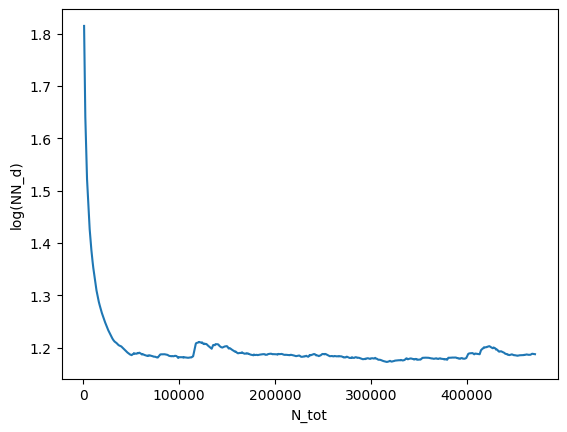

In [37]:
r = stats_df[stats_df.simulation_id == 1477]
plt.plot((r.n_craters_added_in_study_region), np.log10(r.center_to_center_nearest_neighbor_distance_mean))
plt.xlabel("N_tot")
plt.ylabel("log(NN_d)")
plt.show()

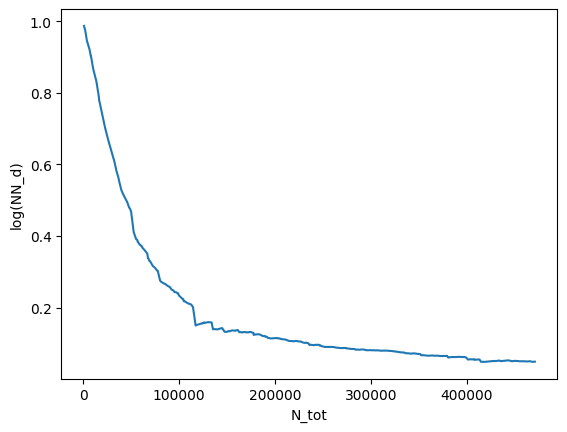

In [38]:
r = stats_df[stats_df.simulation_id == 1477]
plt.plot((r.n_craters_added_in_study_region), r.information_remaining)
plt.xlabel("N_tot")
plt.ylabel("log(NN_d)")
plt.show()

#### Plots of IVs vs IR

I am not sure how to interpret these plots.

At the very least, high IR (near 1) occurs across a wide range of other IVs. This is easily explained: crater destruction has not yet become a factor.

In [ ]:
plt.scatter(np.log(stats_df.n_craters_in_study_region), np.log(stats_df.information_remaining))
plt.xlabel("log(N_r)")
plt.ylabel("log(N)")
plt.show()

In [ ]:
for x in non_constant_ivs:
    plt.scatter(stats_df[x], stats_df.information_remaining)
    plt.xlabel(f"{x}")
    plt.ylabel("IR")
    plt.show()

In [ ]:
for x in non_constant_ivs:
    plt.scatter(np.log(stats_df[x]), stats_df.information_remaining)
    plt.xlabel(f"log({x})")
    plt.ylabel("IR")
    plt.show()

In [ ]:
for x in non_constant_ivs:
    plt.scatter(np.log10(stats_df[x]), stats_df.information_remaining)
    plt.xlabel(f"log({x})")
    plt.ylabel("IR")
    plt.show()

In [ ]:
for x in non_constant_ivs:
    plt.scatter(np.log10(stats_df[x]), np.log10(stats_df.removals))
    plt.xlabel(f"log({x})")
    plt.ylabel("log(removals)")
    plt.show()

In [ ]:
plt.scatter(stats_df.effective_radius_multiplier, np.log10(stats_df.removals))
plt.xlabel(f"effective_radius_multiplier)")
plt.ylabel("log(removals)")
plt.show()

In [ ]:
plt.scatter(stats_df.min_rim_percentage, np.log10(stats_df.removals))
plt.xlabel(f"min_rim_percentage)")
plt.ylabel("log(removals)")
plt.show()

In [ ]:
plt.scatter(stats_df.slope, np.log10(stats_df.removals))
plt.xlabel(f"slope)")
plt.ylabel("log(removals)")
plt.show()

In [ ]:
# Failed experiment
df = stats_df[stats_df.simulation_id == 10].copy()
# df = stats_df[stats_df.information_remaining < 0.95]
# df = df.sample(df.shape[0] // 10).copy()

x_min = 5
mean_r_sq = (df.slope + 1) / df.slope * x_min**2
df["destruction_rate"] = mean_r_sq * df.effective_radius_multiplier ** 2 * df.min_rim_percentage * df.n_craters_in_study_region

fig = px.scatter(
    df,
    x="removals",
    y="destruction_rate",
    hover_data=ivs + ["removals"],
    size_max=0.25,
    color="areal_density"
)
fig.show()

# plt.scatter(df.information_remaining, destruction)
# plt.xlabel("IR")
# plt.ylabel("destruction")
# plt.show()

In [ ]:
def plot_n_destruction_and_ad_for_simulation(simulation_id: int, stats_df: pd.DataFrame):
    df = stats_df[stats_df.simulation_id == simulation_id]
    df.head()
    
    print(df[["slope", "effective_radius_multiplier", "r_stat_multiplier", "min_rim_percentage"]].iloc[0])
    
    fig = plt.figure(figsize=(18, 4))
    ax1 = fig.add_subplot(121)
    
    plt1 = ax1.plot(df.n_craters_added_in_study_region, df.destruction_rate, color='red', label="Destruction Rate")
    ax1.set_ylabel("Destruction Rate")
    ax1.set_xlabel("N Craters Added")
    
    ax2 = ax1.twinx()
    plt2 = ax2.plot(df.n_craters_added_in_study_region, df.areal_density, color="blue", label="Areal Density")
    ax2.set_ylabel("Areal Density")
    
    lns = plt1 + plt2
    ax1.legend(lns, [l.get_label() for l in lns], loc=4)
    
    ax1.set_title(f"Simulation {simulation_id}")


    ax1 = fig.add_subplot(122)
    
    plt1 = ax1.plot(df.n_craters_added_in_study_region, df.information_remaining, color='red', label="Information Remaining")
    ax1.set_ylabel("Information Remaining")
    ax1.set_xlabel("N Craters Added")
    
    ax2 = ax1.twinx()
    plt2 = ax2.plot(df.n_craters_added_in_study_region, df.n_craters_in_study_region, color="blue", label="N Craters Remaining")
    ax2.set_ylabel("Areal Density")
    
    lns = plt1 + plt2
    ax1.legend(lns, [l.get_label() for l in lns], loc=4)
    
    ax1.set_title(f"Simulation {simulation_id}")
    plt.show()

In [ ]:
constant = 4000**2 / 300

df = stats_df[stats_df.slope > 2].copy()
ids = df.simulation_id.unique()

x_min = 5
mean_r_sq = (df.slope - 1) / (df.slope - 2) * x_min**2
df["destruction_rate"] = mean_r_sq * df.effective_radius_multiplier ** 2 * df.min_rim_percentage / df.center_to_center_nearest_neighbor_distance_mean

for x in range(8, 15):
    plot_n_destruction_and_ad_for_simulation(ids[x], df)

#### Plots of N vs IVs

Here, N = count of craters ever to hit the study region.

There appear to be relationships between several IVs and N:
- za: positive correlation
- areal_density: positive correlation

center-to-center and rim-to-rim distance metrics seem to tell a similar story as the IR plots: once crater destruction becomes a factor, N has larger variance. Perhaps examining plots where crater destruction has started will help?

In [ ]:
for x in non_constant_ivs:
    plt.scatter(stats_df[x], stats_df.n_craters_added_in_study_region)
    plt.xlabel(f"{x}")
    plt.ylabel("N")
    plt.show()

In [ ]:
for x in non_constant_ivs:
    plt.scatter(stats_df[x], np.log(stats_df.n_craters_added_in_study_region))
    plt.xlabel(f"{x}")
    plt.ylabel("log(N)")
    plt.show()

In [ ]:
for x in non_constant_ivs:
    plt.scatter(np.log(stats_df[x]), np.log(stats_df.removals))
    plt.xlabel(f"log({x})")
    plt.ylabel("log(N)")
    plt.show()

#### Plots of N vs IVs after crater destruction has started

In [ ]:
df = stats_df[stats_df.information_remaining < 0.8].copy()
for x in non_constant_ivs:
    plt.scatter(df[x], df.n_craters_added_in_study_region)
    plt.xlabel(f"{x}")
    plt.ylabel("N")
    plt.show()

In [ ]:
df = stats_df[stats_df.information_remaining < 0.8].copy()
for x in non_constant_ivs:
    plt.scatter(df[x], np.log(df.n_craters_added_in_study_region))
    plt.xlabel(f"{x}")
    plt.ylabel("log(N)")
    plt.show()

In [ ]:
df = stats_df #[stats_df.information_remaining < 1].copy()
for x in ["center_to_center_nearest_neighbor_distance_mean"]:
    plt.scatter(np.log(df[x]), np.log(df.n_craters_added_in_study_region))
    plt.xlabel(f"log({x})")
    plt.ylabel("log(N)")
    plt.show()

In [ ]:
df = stats_df #[stats_df.information_remaining < 1].copy()
for x in ["center_to_center_nearest_neighbor_distance_mean"]:
    plt.scatter(np.log10(df[x]), np.log10(df.n_craters_added_in_study_region))
    plt.xlabel(f"log({x})")
    plt.ylabel("log(N)")
    plt.show()

In [ ]:
df = stats_df #[stats_df.information_remaining < 1].copy()
for x in ["center_to_center_nearest_neighbor_distance_mean"]:
    plt.scatter(np.log10(df[x]), np.log10(df.information_remaining))
    plt.xlabel(f"log({x})")
    plt.ylabel("log(IR)")
    plt.show()

N appears to have greater variance after some cutoff values of most of the center-to-center and rim-to-rim distance metrics.

Examining these at these more closely with different cutoffs of IR, we find that the thin "tail" at greater values of the distance metrics shrinks. Around IR < 0.5, the tail is mostly gone.

This seems to imply that after about 50% information lost from the record, the behavior of N is different. It has larger variance, but still exhibits a relationship with some IVs.

In [ ]:
distance_metrics = [
    "center_to_center_nearest_neighbor_distance_mean",
    "center_to_center_nearest_neighbor_distance_stdev",
    "center_to_center_nearest_neighbor_distance_min",
    "center_to_center_nearest_neighbor_distance_max",
]

In [ ]:
df = stats_df[stats_df.information_remaining < 0.8].copy()
for x in distance_metrics:
    plt.scatter(np.log(df[x]), np.log(df.n_craters_added_in_study_region))
    plt.xlabel(f"log({x})")
    plt.ylabel("log(N)")
    plt.show()

In [ ]:
df = stats_df[stats_df.information_remaining < 0.5].copy()
for x in distance_metrics:
    plt.scatter(np.log(df[x]), np.log(df.n_craters_added_in_study_region))
    plt.xlabel(f"log({x})")
    plt.ylabel("log(N)")
    plt.show()

Examining correlation matrices of observations with high vs low IR.

- IR vs distance metrics correlations greatly diminishes when IR is low.
- Effective radius correlation increases in higher IR.
- Min rim percentage correlation increases in higher IR.

In [ ]:
df = stats_df[stats_df.information_remaining > 0.7].copy()
sns.heatmap(df[ivs + ["information_remaining", "n_craters_added_in_study_region"]].corr())

In [ ]:
df = stats_df[stats_df.information_remaining < 0.5].copy()
sns.heatmap(df[ivs + ["information_remaining", "n_craters_added_in_study_region"]].corr())

Correlation differences between high IR and low IR observations.

First heatmap: positive = higher correlation in high IR

Second heatmap: abs differences in correlations

Third heatmap: abs differences in correlations of log-transformed data

Notes:
- Slope has higher correlation with distance metrics in high IR
- z, za, and AD metrics have higher correlation with high IR
- Sim parameters (eff radius, r_stat, slope, min rim perc) appear to have the same correlation in high and low IR
- Log-transformed distance metrics have much higher correlation with high IR

In [ ]:
df = stats_df[stats_df.information_remaining > 0.7].copy()
corr1 = df[ivs + ["information_remaining", "n_craters_added_in_study_region"]].corr()

df = stats_df[stats_df.information_remaining < 0.5].copy()
corr2 = df[ivs + ["information_remaining", "n_craters_added_in_study_region"]].corr()

sns.heatmap(corr1 - corr2)

In [ ]:
df = stats_df[stats_df.information_remaining > 0.7].copy()
corr1 = df[ivs + ["information_remaining", "n_craters_added_in_study_region"]].corr()

df = stats_df[stats_df.information_remaining < 0.5].copy()
corr2 = df[ivs + ["information_remaining", "n_craters_added_in_study_region"]].corr()

sns.heatmap(np.abs(corr1 - corr2))

In [ ]:
df = np.log(stats_df[stats_df.information_remaining > 0.7].copy())
corr1 = df[ivs + ["information_remaining", "n_craters_added_in_study_region"]].corr()

df = np.log(stats_df[stats_df.information_remaining < 0.5].copy())
corr2 = df[ivs + ["information_remaining", "n_craters_added_in_study_region"]].corr()

sns.heatmap(np.abs(corr1 - corr2))

#### Exploratory plots of distance metrics

mean center-to-center nearest neighbor distance showed a peculiar relationship in the previous sections. Let's examine further.

In [ ]:
df = stats_df #[stats_df.information_remaining < 0.5].copy()
# df = stats_df.copy()
df = df.sample(df.shape[0] // 10).copy()
df["log_center_to_center_nearest_neighbor_distance_mean"] = np.log10(df.center_to_center_nearest_neighbor_distance_mean)
df["log_n_craters_added_in_study_region"] = np.log10(df.n_craters_added_in_study_region)

df["log_center_to_center_nearest_neighbor_distance_mean"] = np.log10(df.center_to_center_nearest_neighbor_distance_mean)
df["log_removals"] = np.log10(1 + df.removals)
df["log_areal_density"] = np.log10(df.areal_density)
df["color"] = df.min_rim_percentage * df.effective_radius_multiplier

fig = px.scatter(
    df,
    x="log_removals",
    y="log_areal_density",
    hover_data=ivs + ["removals", "information_remaining"],
    size_max=0.25,
    color="slope"
)
fig.show()

In [ ]:
ir_lower = 0.4
delta = 0.01
# df = stats_df[(stats_df.information_remaining >= ir_lower) & (stats_df.information_remaining <= ir_lower + delta)].copy()
# df = stats_df[stats_df.simulation_id == 11].copy()
df = stats_df.copy()
df = df.sample(df.shape[0] // 10).copy()
df["log_center_to_center_nearest_neighbor_distance_mean"] = np.log10(df.center_to_center_nearest_neighbor_distance_mean)
df["log_n_craters_added_in_study_region"] = np.log10(df.n_craters_added_in_study_region)
df["log_za"] = np.log10(df.za)

df["log_center_to_center_nearest_neighbor_distance_mean"] = np.log10(df.center_to_center_nearest_neighbor_distance_mean)
df["log_removals"] = np.log10(1 + df.n_craters_added_in_study_region - df.n_craters_in_study_region)
df["removals"] = df.n_craters_added_in_study_region - df.n_craters_in_study_region
df["color"] = df.min_rim_percentage * df.effective_radius_multiplier
df["e_slope"] = np.exp(df.slope)

fig = px.scatter(
    df,
    y="log_n_craters_added_in_study_region",
    x="log_center_to_center_nearest_neighbor_distance_mean",
    hover_data=ivs + ["removals"],
    size_max=1,
    color="slope",
)
fig.show()

In [113]:
base_path = "/data/saturation/random_runs_20230812/"
# base_path = "/data/saturation/ir_random_1/"
# base_path = "/data/saturation/n_craters_stop_condition_20230918"

# stats_df = pd.read_parquet(f"{base_path}/train_1000_100.parquet").sort_values("crater_id")
stats_df = pd.read_parquet(f"{base_path}/train_10.parquet").sort_values("crater_id")
stats_df = fix_up_df(stats_df)

# test_df = pd.read_parquet(f"{base_path}/test_1000_100.parquet").sort_values("crater_id")
test_df = pd.read_parquet(f"{base_path}/test_10.parquet").sort_values("crater_id")
test_df = fix_up_df(test_df)

simulation_ids = stats_df.simulation_id.unique()

In [163]:
df = stats_df.copy()
df = df[df.n_craters_in_study_region > 25]
# df = df.sample(df.shape[0] // 10).copy()

min_slope = 2.0
max_slope = 2.1

df = df[(df.slope > min_slope) & (df.slope < max_slope)]
df["log_center_to_center_nearest_neighbor_distance_mean"] = np.log10(df.center_to_center_nearest_neighbor_distance_mean)
df["log_n_craters_added_in_study_region"] = np.log10(df.n_craters_added_in_study_region)
df["log_n_craters_in_study_region"] = np.log10(df.n_craters_in_study_region)

fig = px.scatter(
    df,
    x="log_center_to_center_nearest_neighbor_distance_mean",
    y="log_n_craters_added_in_study_region",
    hover_data=ivs + ["information_remaining"],
    size_max=1,
    color="log_n_craters_in_study_region",
)
fig.show()

In [161]:
from saturation.distributions import ProbabilityDistribution, ParetoProbabilityDistribution

slope = 2
x_min = 5
x_max = 1000

size_distribution = ParetoProbabilityDistribution(cdf_slope=slope,
                                                  x_min=x_min,
                                                  x_max=x_max)
size_distribution.pullback(np.random.rand(10000)).mean()

9.821004080330002

In [200]:
# Trying to approximate variance
df = stats_df.copy()

slope_center = 2
slope_epsilon = .1
min_slope = slope_center - slope_epsilon
max_slope = slope_center + slope_epsilon
interior_min = slope_center - slope_epsilon / 2
interior_max = slope_center + slope_epsilon / 2

calc_df = df[(df.slope >= interior_min) & (df.slope < interior_max)].sort_values("center_to_center_nearest_neighbor_distance_mean").copy()
search_df = df[(df.slope >= min_slope) & (df.slope < max_slope)][["center_to_center_nearest_neighbor_distance_mean"]].sort_values("center_to_center_nearest_neighbor_distance_mean").reset_index(drop=True).copy()
search_df["idx"] = range(search_df.shape[0])

results = []
for row in calc_df.itertuples():
    print(row.Index)
    break

268440


In [202]:
search_df

,center_to_center_nearest_neighbor_distance_mean,idx
0,0.000000,0
1,0.000000,1
2,0.000000,2
3,0.000000,3
4,0.000000,4
...,...,...
40705,2940.310547,40705
40706,2961.814941,40706
40707,2967.325928,40707
40708,3666.637451,40708


In [201]:
merged = pd.merge_asof(
    calc_df,
    search_df,
    left_on="center_to_center_nearest_neighbor_distance_mean",
    right_on="center_to_center_nearest_neighbor_distance_mean",
    allow_exact_matches=False,
    direction="nearest"
)

In [191]:
search_df.reset_index()

,index,simulation_id,crater_id,n_craters_added_in_study_region,n_craters_in_study_region,areal_density,areal_density_overlap_2,areal_density_overlap_3,center_to_center_nearest_neighbor_distance_mean,center_to_center_nearest_neighbor_distance_stdev,...,rim_to_rim_nearest_neighbor_distance_max,n_non_zero_rim_to_rim_nearest_neighbor_distances,z,za,information_remaining,effective_radius_multiplier,min_rim_percentage,r_stat_multiplier,slope,removals
0,268440,10,2,1,1,0.000015,0.0,0.0,0.000000,0.0,...,0.000000,0,0.000000,0.000000,1.0,1.187143,0.708349,7.099577,1.994618,0
1,215278,2309,73,1,1,0.000006,0.0,0.0,0.000000,0.0,...,0.000000,0,0.000000,0.000000,1.0,1.874091,0.513008,3.897285,1.953064,0
2,279029,2404,38,1,1,0.000008,0.0,0.0,0.000000,0.0,...,0.000000,0,0.000000,0.000000,1.0,1.663088,0.443837,6.159380,2.049174,0
3,133252,2500,64,1,1,0.000008,0.0,0.0,0.000000,0.0,...,0.000000,0,0.000000,0.000000,1.0,1.645326,0.538338,6.587640,2.073390,0
4,141787,1206,23,1,1,0.000022,0.0,0.0,0.000000,0.0,...,0.000000,0,0.000000,0.000000,1.0,1.649914,0.267792,4.405230,2.099258,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40705,305426,1351,24,2,2,0.000025,0.0,0.0,2940.310547,0.0,...,2925.154541,2,2.919530,2.919600,1.0,1.705948,0.672229,7.395973,2.002413,0
40706,210419,595,43,2,2,0.000019,0.0,0.0,2961.814941,0.0,...,2947.882324,2,2.960670,2.960724,1.0,1.368665,0.263233,5.652390,1.977874,0
40707,260140,1075,63,1,1,0.000006,0.0,0.0,2967.325928,0.0,...,2956.116455,1,0.000000,0.000000,1.0,1.464989,0.386049,6.714479,1.994093,0
40708,282115,1335,13,2,2,0.000021,0.0,0.0,3666.637451,0.0,...,3652.338135,2,4.309045,4.309118,1.0,1.783780,0.255604,4.338353,1.924827,0


In [155]:
# Dione 1
d_min = 4000 # meters
r_min = d_min / 2
area = 102449 # km^2
n_craters = 65

area_m = area * 1000**2
area_r_min = area_m / r_min**2
intensity = n_craters / area_r_min
intensity

0.002537848100030259

In [165]:
# Dione 2
d_min = 4000 # meters
r_min = d_min / 2
area = 62647 # km^2
n_craters = 192

area_m = area * 1000**2
area_r_min = area_m / r_min**2
intensity = n_craters / area_r_min
intensity

0.01225916644053187

In [168]:
# Dione 3
d_min = 4000 # meters
r_min = d_min / 2
area = 53552 # km^2
n_craters = 265

area_m = area * 1000**2
area_r_min = area_m / r_min**2
intensity = n_craters / area_r_min
intensity

0.019793845234538393

In [167]:
# Dione 4
d_min = 4000 # meters
r_min = d_min / 2
area = 38712 # km^2
n_craters = 265

area_m = area * 1000**2
area_r_min = area_m / r_min**2
intensity = n_craters / area_r_min
intensity

0.02738169043190742

In [164]:
# Sim terrain
r_min = 5 # units
area = 4000**2 # unit^2
n_craters = 3500

area_r_min = area / r_min**2
intensity = n_craters / area_r_min
intensity

0.00546875

In [131]:
"""
slope 1.1 -> 22.27, c2c_mean ~= 105
slope 1.5 -> 13.78, c2c_mean ~= 50
slope 2   -> 9.81,  c2c_mean ~= 31
slope 2.2 -> 9.15,  c2c_mean ~= 29.6
slope 2.5 -> 8.26,  c2c_mean ~= 26
slope 2.9 -> 7.635, c2c_mean ~= 24
"""

'\nslope 1.5 -> 13.78\nslope 2   -> 9.81\nslope 2   -> 8.26\nslope 2   -> 7.39\n'

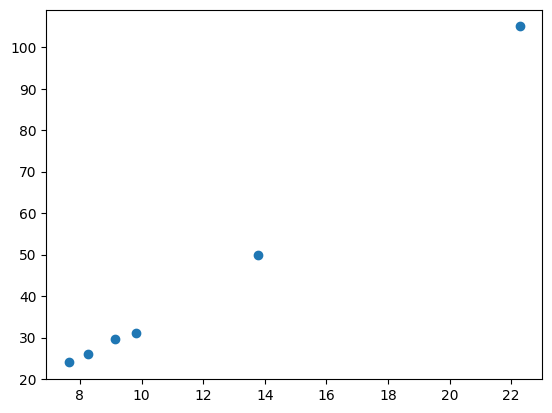

In [151]:
plt.scatter([22.27, 13.78, 9.81, 9.15, 8.26, 7.635], [105, 50, 31, 29.6, 26, 24])

In [147]:
stats.linregress([22.27, 13.78, 9.81, 8.26, 7.635], [105, 50, 31, 26, 24])

LinregressResult(slope=5.584886888462277, intercept=-21.77893795939758, rvalue=0.9946345247542254, pvalue=0.0004714073100586269, stderr=0.3353713724222027, intercept_stderr=4.520921102807019)

### Modeling variance

Goal: model the variance (with a CI) of N given c2c_mean, slope
- Linear regression first
- Response: log sqrt (variance of N)
    - Possibly bucketed to calculate variance



In [54]:
df = stats_df.copy()
df = df.sample(df.shape[0] // 10).copy()
df["log_center_to_center_nearest_neighbor_distance_mean"] = np.log10(df.center_to_center_nearest_neighbor_distance_mean)
df["log_n_craters_added_in_study_region"] = np.log10(df.n_craters_added_in_study_region)

fig = px.scatter_3d(
    df,
    x="slope",
    y="log_center_to_center_nearest_neighbor_distance_mean",
    z="log_n_craters_added_in_study_region",
    hover_data=ivs + ["removals"],
    size_max=1,
    color="effective_radius_multiplier",
    width=1600,
    height=800
)
fig.update_traces(marker={"size":3})
fig.show()

/home/mason/code/saturation/venv_311/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning:

divide by zero encountered in log10



In [6]:
# base_path = "/data/saturation/random_runs_20230812/"
# base_path = "/data/saturation/ir_random_1/"
base_path = "/data/saturation/n_craters_stop_condition_20230918"

stats_df = pd.read_parquet(f"{base_path}/train_1000_100.parquet").sort_values("crater_id")
# stats_df = pd.read_parquet(f"{base_path}/train_10.parquet").sort_values("crater_id")
stats_df = fix_up_df(stats_df)

test_df = pd.read_parquet(f"{base_path}/test_1000_100.parquet").sort_values("crater_id")
# test_df = pd.read_parquet(f"{base_path}/test_10.parquet").sort_values("crater_id")
test_df = fix_up_df(test_df)

simulation_ids = stats_df.simulation_id.unique()

In [12]:
stats_df["log_center_to_center_nearest_neighbor_distance_mean"] = np.log10(stats_df.center_to_center_nearest_neighbor_distance_mean)
stats_df["log_n_craters_added_in_study_region"] = np.log10(stats_df.n_craters_added_in_study_region)

/home/mason/code/saturation/venv_311/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning:

divide by zero encountered in log10



In [13]:
df = stats_df.copy()
df = df.sample(df.shape[0] // 10).copy()

fig = px.scatter(
    df,
    x="log_center_to_center_nearest_neighbor_distance_mean",
    y="log_n_craters_added_in_study_region",
    hover_data=ivs + ["information_remaining"],
    size_max=1,
    color="information_remaining",
)
fig.show()

In [60]:
df = stats_df.copy()
df = df.sample(df.shape[0] // 10).copy()
df["log_center_to_center_nearest_neighbor_distance_mean"] = np.log10(df.center_to_center_nearest_neighbor_distance_mean)
df["log_n_craters_added_in_study_region"] = np.log10(df.n_craters_added_in_study_region)

fig = px.scatter_3d(
    df,
    x="slope",
    y="log_center_to_center_nearest_neighbor_distance_mean",
    z="log_n_craters_added_in_study_region",
    hover_data=ivs + ["removals"],
    size_max=1,
    color="effective_radius_multiplier",
    width=1600,
    height=800
)
fig.update_traces(marker={"size":3})
fig.show()

In [72]:
# base_path = "/data/saturation/random_runs_20230812/"
# base_path = "/data/saturation/ir_random_1/"
base_path = "/data/saturation/n_craters_stop_condition_20230918"

stats_df = pd.read_parquet(f"{base_path}/train_1000_500.parquet").sort_values("crater_id")
# stats_df = pd.read_parquet(f"{base_path}/train_10.parquet").sort_values("crater_id")
stats_df = fix_up_df(stats_df)

test_df = pd.read_parquet(f"{base_path}/test_1000_500.parquet").sort_values("crater_id")
# test_df = pd.read_parquet(f"{base_path}/test_10.parquet").sort_values("crater_id")
test_df = fix_up_df(test_df)

simulation_ids = stats_df.simulation_id.unique()

In [88]:
def plot_n_vs_N_for_simulation(simulation_id: int, stats_df: pd.DataFrame):
    df = stats_df[stats_df.simulation_id == simulation_id]
    
    print(df[["slope", "effective_radius_multiplier", "r_stat_multiplier", "min_rim_percentage"]].iloc[0])
    
    fig = plt.figure(figsize=(18, 4))
    ax1 = fig.add_subplot(111)
    
    plt1 = ax1.plot(df.n_craters_added_in_study_region, df.n_craters_in_study_region, color='red')
    ax1.set_ylabel("n")
    ax1.set_xlabel("N")
    
    ax1.set_title(f"Simulation {simulation_id}")
    plt.show()


def plot_n_hist_for_simulation(simulation_id: int, stats_df: pd.DataFrame):
    df = stats_df[stats_df.simulation_id == simulation_id]
    min_N = int(df.n_craters_added_in_study_region.max() * 2 / 3)
    df = df[df.n_craters_added_in_study_region > min_N]
   
    print(df[["slope", "effective_radius_multiplier", "r_stat_multiplier", "min_rim_percentage"]].iloc[0])
    
    plt.hist(df.n_craters_in_study_region, bins=25)
    plt.show()

slope                          2.078635
effective_radius_multiplier    1.523039
r_stat_multiplier              3.984255
min_rim_percentage             0.535537
Name: 255259, dtype: float64


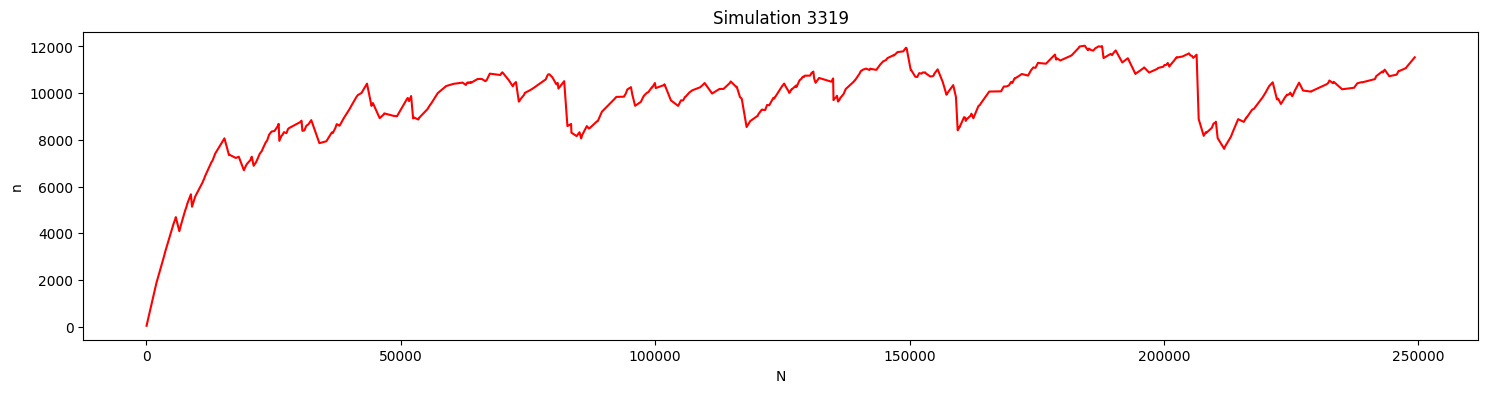

In [78]:
for x in range(29, 30):
    plot_n_vs_N_for_simulation(simulation_ids[x], stats_df)

slope                          2.078635
effective_radius_multiplier    1.523039
r_stat_multiplier              3.984255
min_rim_percentage             0.535537
Name: 255416, dtype: float64


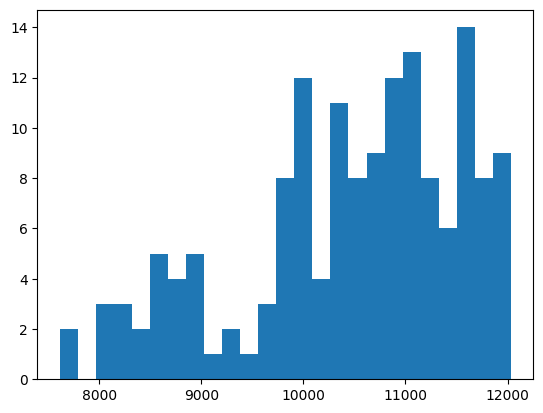

In [89]:
for x in range(29, 30):
    plot_n_hist_for_simulation(simulation_ids[x], stats_df)

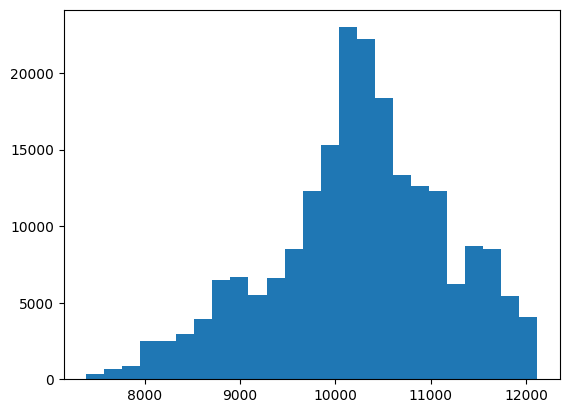

In [102]:
sim_dir = "1.523_0.536_3.984_2.079"

df = None
for filename in glob.glob(f"/data/saturation/n_craters_stop_condition_20230918/{sim_dir}/statistics*.parquet"):
    if df is None:
        df = pd.read_parquet(filename)
    else:
        df = pd.concat([df, pd.read_parquet(filename)], axis=0)

min_N = int(df.n_craters_added_in_study_region.max() * 2 / 3)
# plt.hist(df[df.n_craters_added_in_study_region > min_N].n_craters_in_study_region, bins=25)
plt.hist(df[df.n_craters_added_in_study_region > 40000].n_craters_in_study_region, bins=25)
plt.show()

In [108]:
df[df.n_craters_added_in_study_region > min_N].n_craters_in_study_region.quantile(0.01)

7676.0

In [ ]:
df[df.n_craters_added_in_study_region > 40000].n_craters_in_study_region.quantile(0.01)